In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    #model.add(layers.Dense(2, activation='relu'))
        
    model.add(layers.Dense(2, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 10317.8115 - mae: 44.3161 - mape: 2886.0254 - student_loss: 44.1731 - distillation_loss: 10272.5670 - val_mse: 161.0088 - val_mae: 8.5795 - val_mape: 557.7579 - val_student_loss: 10.6847
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 100.7792 - mae: 6.5960 - mape: 393.1342 - student_loss: 6.5917 - distillation_loss: 99.0282 - val_mse: 83.8583 - val_mae: 5.4702 - val_mape: 325.2153 - val_student_loss: 6.7453
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 45.0699 - mae: 3.4829 - mape: 194.9919 - student_loss: 3.4845 - distillation_loss: 43.9088 - val_mse: 44.4095 - val_mae: 2.6841 - val_mape: 179.2259 - val_student_loss: 2.7840
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 28.7958 - mae: 2.4311 - mape: 153.4325 - student_loss: 2.4344 - distillation_loss: 27.9204 - val_mse: 32.9349 - val_mae: 2.2715 - val_mape: 165.9159 - val_st

443/443 [==============================] - 1s 2ms/step - mse: 0.6620 - mae: 0.6125 - mape: 39.8930 - student_loss: 0.6127 - distillation_loss: 0.2267 - val_mse: 0.5592 - val_mae: 0.5657 - val_mape: 36.0573 - val_student_loss: 0.6495
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6047 - mae: 0.5925 - mape: 38.5959 - student_loss: 0.5912 - distillation_loss: 0.1733 - val_mse: 0.5428 - val_mae: 0.5634 - val_mape: 37.0608 - val_student_loss: 0.6508
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6957 - mae: 0.6302 - mape: 41.0850 - student_loss: 0.6305 - distillation_loss: 0.2588 - val_mse: 0.5369 - val_mae: 0.5742 - val_mape: 39.5918 - val_student_loss: 0.6883
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 2.2855 - mae: 0.7934 - mape: 51.7988 - student_loss: 0.7932 - distillation_loss: 1.8479 - val_mse: 0.5895 - val_mae: 0.5679 - val_mape: 32.9261 - val_student_loss: 0.6791
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5063 - mae: 0.5349 - mape: 34.1876 - student_loss: 0.5363 - distillation_loss: 0.1069 - val_mse: 0.4834 - val_mae: 0.5145 - val_mape: 32.3500 - val_student_loss: 0.5885
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 399.4146 - mse: 440527.8125 - mae: 399.4146 - mape: 26333.6465 - val_loss: 26.3389 - val_mse: 1351.2311 - val_mae: 26.3389 - val_mape: 1838.7642
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 21.6448 - mse: 914.5154 - mae: 21.6448 - mape: 1449.9606 - val_loss: 15.5673 - val_mse: 509.6509 - val_mae: 15.5673 - val_mape: 1089.5840
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 9.6947 - mse: 219.5491 - mae: 9.6947 - mape: 647.1053 - val_loss: 3.1140 - val_mse: 32.7152 - val_mae: 3.1140 - val_mape: 225.4826
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0600 - mse: 10.0571 - mae: 1.0600 - mape: 66.9899 -

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5896 - mse: 0.9006 - mae: 0.5896 - mape: 35.7812 - val_loss: 0.7320 - val_mse: 1.0401 - val_mae: 0.7320 - val_mape: 54.1683
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6088 - mse: 0.9112 - mae: 0.6088 - mape: 37.2873 - val_loss: 0.9253 - val_mse: 1.4452 - val_mae: 0.9253 - val_mape: 70.1105
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6148 - mse: 0.8886 - mae: 0.6148 - mape: 37.7538 - val_loss: 0.5147 - val_mse: 0.7201 - val_mae: 0.5147 - val_mape: 31.6636
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5797 - mse: 0.7897 - mae: 0.5797 - mape: 35.1625 - val_loss: 1.0278 - val_mse: 1.8283 - val_mae: 1.0278 - val_mape: 77.2846
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6444 - mse: 1.0409 - mae: 0.6444 - mape: 39.4684 - val_loss: 0.8595 - val_mse: 1.5590 - val_mae: 0.8595 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7810 - mape: 56.0607 - student_loss: 0.7822 - distillation_loss: 0.5150 - val_mse: 0.9642 - val_mae: 0.7885 - val_mape: 55.9956 - val_student_loss: 0.8039
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7815 - mape: 56.1962 - student_loss: 0.7813 - distillation_loss: 0.5122 - val_mse: 0.9645 - val_mae: 0.7875 - val_mape: 55.7269 - val_student_loss: 0.7965
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7809 - mape: 56.0619 - student_loss: 0.7812 - distillation_loss: 0.5122 - val_mse: 0.9643 - val_mae: 0.7882 - val_mape: 55.8966 - val_student_loss: 0.8012
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7808 - mape: 56.0420 - student_loss: 0.7810 - distillation_loss: 0.5117 - val_mse: 0.9642 - val_mae: 0.7888 - val_mape: 56.0611 - val_student_loss: 0.8057
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9499 - mae: 0.7816 - mape: 56.2396 - student_loss: 0.7836 - distillation_loss: 0.5143 - val_mse: 0.9645 - val_mae: 0.7875 - val_mape: 55.7256 - val_student_loss: 0.7965
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7808 - mape: 56.0439 - student_loss: 0.7828 - distillation_loss: 0.5140 - val_mse: 0.9644 - val_mae: 0.7881 - val_mape: 55.8762 - val_student_loss: 0.8006
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7814 - mape: 56.2178 - student_loss: 0.7810 - distillation_loss: 0.5118 - val_mse: 0.9647 - val_mae: 0.7872 - val_mape: 55.6480 - val_student_loss: 0.7943
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7810 - mape: 56.0940 - student_loss: 0.7822 - distillation_loss: 0.5133 - val_mse: 0.9646 - val_mae: 0.7874 - val_mape: 55.6869 - val_student_loss: 0.7954
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9813 - mae: 0.7691 - mape: 50.6966 - val_loss: 0.7766 - val_mse: 1.0032 - val_mae: 0.7766 - val_mape: 50.1140
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9845 - mae: 0.7691 - mape: 50.4513 - val_loss: 0.7766 - val_mse: 1.0024 - val_mae: 0.7766 - val_mape: 50.1739
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9845 - mae: 0.7691 - mape: 50.4479 - val_loss: 0.7766 - val_mse: 1.0011 - val_mae: 0.7766 - val_mape: 50.2730
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9834 - mae: 0.7691 - mape: 50.5348 - val_loss: 0.7766 - val_mse: 1.0012 - val_mae: 0.7766 - val_mape: 50.2593
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9834 - mae: 0.7691 - mape: 50.5347 - val_loss: 0.7766 - val_mse: 1.0018 - val_mae: 0.7766 - val_mape

443/443 [==============================] - 1s 2ms/step - mse: 8.5816 - mae: 1.5292 - mape: 84.7218 - student_loss: 1.5286 - distillation_loss: 7.9983 - val_mse: 2.0059 - val_mae: 1.0645 - val_mape: 53.1772 - val_student_loss: 0.7007
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9402 - mae: 1.0125 - mape: 54.8309 - student_loss: 1.0119 - distillation_loss: 1.4135 - val_mse: 1.3215 - val_mae: 0.8639 - val_mape: 51.0795 - val_student_loss: 0.6446
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2004 - mae: 0.8271 - mape: 50.3461 - student_loss: 0.8270 - distillation_loss: 0.7181 - val_mse: 0.9593 - val_mae: 0.7666 - val_mape: 49.9824 - val_student_loss: 0.7021
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9284 - mae: 0.7596 - mape: 52.2773 - student_loss: 0.7603 - distillation_loss: 0.4795 - val_mse: 0.8872 - val_mae: 0.7644 - val_mape: 55.7966 - val_student_loss: 0.7065
Epoch 5/100
443/443 [===========

443/443 [==============================] - 1s 2ms/step - mse: 0.5226 - mae: 0.5481 - mape: 35.2960 - student_loss: 0.5478 - distillation_loss: 0.1119 - val_mse: 0.4992 - val_mae: 0.5431 - val_mape: 36.2541 - val_student_loss: 0.5398
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5196 - mae: 0.5460 - mape: 35.1151 - student_loss: 0.5454 - distillation_loss: 0.1043 - val_mse: 0.5072 - val_mae: 0.5531 - val_mape: 37.4886 - val_student_loss: 0.5442
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5381 - mae: 0.5538 - mape: 35.7162 - student_loss: 0.5534 - distillation_loss: 0.1256 - val_mse: 0.4937 - val_mae: 0.5298 - val_mape: 34.2765 - val_student_loss: 0.5375
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5091 - mae: 0.5427 - mape: 34.9005 - student_loss: 0.5423 - distillation_loss: 0.0974 - val_mse: 0.4956 - val_mae: 0.5217 - val_mape: 32.7365 - val_student_loss: 0.5361
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - loss: 0.5260 - mse: 0.5051 - mae: 0.5260 - mape: 32.5334 - val_loss: 0.5345 - val_mse: 0.4848 - val_mae: 0.5345 - val_mape: 36.1630
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5171 - mse: 0.4878 - mae: 0.5171 - mape: 31.8949 - val_loss: 0.5033 - val_mse: 0.4754 - val_mae: 0.5033 - val_mape: 30.2337
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5129 - mse: 0.4797 - mae: 0.5129 - mape: 31.5726 - val_loss: 0.5014 - val_mse: 0.4668 - val_mae: 0.5014 - val_mape: 30.6297
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5142 - mse: 0.4800 - mae: 0.5142 - mape: 31.8206 - val_loss: 0.5084 - val_mse: 0.4620 - val_mae: 0.5084 - val_mape: 32.5370
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5198 - mse: 0.4902 - mae: 0.5198 - mape: 32.1230 - val_loss: 0.5240 - val_mse: 0.5230 - val_mae: 0.5240 - val_mape: 29.4558
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4920 - mse: 0.4422 - mae: 0.4920 - mape: 30.0868 - val_loss: 0.4845 - val_mse: 0.4189 - val_mae: 0.4845 - val_mape: 30.6052
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4893 - mse: 0.4398 - mae: 0.4893 - mape: 29.8680 - val_loss: 0.4759 - val_mse: 0.4192 - val_mae: 0.4759 - val_mape: 29.0509
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4879 - mse: 0.4393 - mae: 0.4879 - mape: 29.6052 - val_loss: 0.4793 - val_mse: 0.4175 - val_mae: 0.4793 - val_mape: 29.7581
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4867 - mse: 0.4384 - mae: 0.4867 - mape: 29.6859 - val_loss: 0.4840 - val_mse: 0.4484 - val_mae: 0.4840 - val_mape: 27.9888
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4890 - mse: 0.4437 - mae: 0.4890 - mape: 29.8066 - val_loss: 0.5402 - val_mse: 0.5464 - val_mae: 0.5402 - val_mape

443/443 [==============================] - 1s 2ms/step - mse: 0.9543 - mae: 0.7823 - mape: 55.7802 - student_loss: 0.7841 - distillation_loss: 0.5156 - val_mse: 0.9293 - val_mae: 0.7752 - val_mape: 58.1275 - val_student_loss: 0.5682
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9539 - mae: 0.7832 - mape: 56.0005 - student_loss: 0.7834 - distillation_loss: 0.5151 - val_mse: 0.9288 - val_mae: 0.7735 - val_mape: 57.7816 - val_student_loss: 0.5597
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9544 - mae: 0.7826 - mape: 55.8419 - student_loss: 0.7818 - distillation_loss: 0.5148 - val_mse: 0.9288 - val_mae: 0.7732 - val_mape: 57.7163 - val_student_loss: 0.5580
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9540 - mae: 0.7830 - mape: 55.9437 - student_loss: 0.7817 - distillation_loss: 0.5155 - val_mse: 0.9286 - val_mae: 0.7724 - val_mape: 57.5512 - val_student_loss: 0.5540
Epoch 54/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9875 - mae: 0.7717 - mape: 50.5107 - val_loss: 0.7525 - val_mse: 0.9494 - val_mae: 0.7525 - val_mape: 51.5669
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9876 - mae: 0.7717 - mape: 50.5030 - val_loss: 0.7527 - val_mse: 0.9487 - val_mae: 0.7527 - val_mape: 51.6503
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9880 - mae: 0.7717 - mape: 50.4649 - val_loss: 0.7529 - val_mse: 0.9477 - val_mae: 0.7529 - val_mape: 51.7689
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9866 - mae: 0.7717 - mape: 50.5854 - val_loss: 0.7526 - val_mse: 0.9490 - val_mae: 0.7526 - val_mape: 51.6138
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9876 - mae: 0.7717 - mape: 50.4853 - val_loss: 0.7527 - val_mse: 0.9487 - val_mae: 0.7527 - val_mape

Fold 4
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - mse: 3.9019 - mae: 1.7142 - mape: 85.5008 - student_loss: 1.7118 - distillation_loss: 3.4404 - val_mse: 3.2837 - val_mae: 1.5303 - val_mape: 71.4744 - val_student_loss: 1.1409
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.6998 - mae: 1.3275 - mape: 60.1573 - student_loss: 1.3300 - distillation_loss: 2.2562 - val_mse: 2.2903 - val_mae: 1.1915 - val_mape: 52.0234 - val_student_loss: 0.8770
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9112 - mae: 1.0491 - mape: 46.8162 - student_loss: 1.0493 - distillation_loss: 1.4600 - val_mse: 1.6536 - val_mae: 0.9740 - val_mape: 44.7956 - val_student_loss: 0.7181
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4240 - mae: 0.8855 - mape: 43.4554 - student_loss: 0.8852 - distillation_loss: 0.9809 - val_mse: 1.2794 - val_mae: 0.8499 - val_mape: 44.0903 - val_student_loss: 0.5938
Epoch 5/100
4

443/443 [==============================] - 1s 2ms/step - mse: 0.9524 - mae: 0.7823 - mape: 56.1707 - student_loss: 0.7831 - distillation_loss: 0.5158 - val_mse: 0.9445 - val_mae: 0.7768 - val_mape: 55.0574 - val_student_loss: 0.6116
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7817 - mape: 55.9896 - student_loss: 0.7811 - distillation_loss: 0.5140 - val_mse: 0.9437 - val_mae: 0.7780 - val_mape: 55.4207 - val_student_loss: 0.6168
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7824 - mape: 56.2026 - student_loss: 0.7841 - distillation_loss: 0.5158 - val_mse: 0.9447 - val_mae: 0.7765 - val_mape: 54.9601 - val_student_loss: 0.6101
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9527 - mae: 0.7820 - mape: 56.0765 - student_loss: 0.7838 - distillation_loss: 0.5174 - val_mse: 0.9446 - val_mae: 0.7766 - val_mape: 54.9825 - val_student_loss: 0.6105
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - loss: 0.5014 - mse: 0.4642 - mae: 0.5014 - mape: 30.5162 - val_loss: 0.5040 - val_mse: 0.4440 - val_mae: 0.5040 - val_mape: 32.1216
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5015 - mse: 0.4635 - mae: 0.5015 - mape: 30.5260 - val_loss: 0.4918 - val_mse: 0.4449 - val_mae: 0.4918 - val_mape: 29.3238
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4987 - mse: 0.4590 - mae: 0.4987 - mape: 30.4181 - val_loss: 0.5045 - val_mse: 0.4523 - val_mae: 0.5045 - val_mape: 31.4269
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4983 - mse: 0.4575 - mae: 0.4983 - mape: 30.3877 - val_loss: 0.4984 - val_mse: 0.4624 - val_mae: 0.4984 - val_mape: 28.5639
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4965 - mse: 0.4564 - mae: 0.4965 - mape: 30.1107 - val_loss: 0.4919 - val_mse: 0.4395 - val_mae: 0.4919 - val_mape: 30.0212
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4914 - mse: 0.4426 - mae: 0.4914 - mape: 30.1946 - val_loss: 0.5148 - val_mse: 0.4566 - val_mae: 0.5148 - val_mape: 33.1727
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4913 - mse: 0.4433 - mae: 0.4913 - mape: 30.0144 - val_loss: 0.5236 - val_mse: 0.4568 - val_mae: 0.5236 - val_mape: 34.7378
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4914 - mse: 0.4431 - mae: 0.4914 - mape: 30.1864 - val_loss: 0.4825 - val_mse: 0.4286 - val_mae: 0.4825 - val_mape: 28.5785
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4911 - mse: 0.4433 - mae: 0.4911 - mape: 30.1140 - val_loss: 0.4804 - val_mse: 0.4214 - val_mae: 0.4804 - val_mape: 29.1272
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4904 - mse: 0.4420 - mae: 0.4904 - mape: 30.0540 - val_loss: 0.4858 - val_mse: 0.4365 - val_mae: 0.4858 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7806 - mape: 55.8818 - student_loss: 0.7802 - distillation_loss: 0.5147 - val_mse: 0.9663 - val_mae: 0.7853 - val_mape: 56.1009 - val_student_loss: 0.9170
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9498 - mae: 0.7815 - mape: 56.1115 - student_loss: 0.7799 - distillation_loss: 0.5134 - val_mse: 0.9667 - val_mae: 0.7840 - val_mape: 55.7750 - val_student_loss: 0.9170
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9499 - mae: 0.7808 - mape: 55.9350 - student_loss: 0.7794 - distillation_loss: 0.5138 - val_mse: 0.9665 - val_mae: 0.7845 - val_mape: 55.8942 - val_student_loss: 0.9170
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9497 - mae: 0.7804 - mape: 55.8535 - student_loss: 0.7797 - distillation_loss: 0.5129 - val_mse: 0.9660 - val_mae: 0.7865 - val_mape: 56.3663 - val_student_loss: 0.9170
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9490 - mae: 0.7810 - mape: 56.0830 - student_loss: 0.7796 - distillation_loss: 0.5125 - val_mse: 0.9667 - val_mae: 0.7841 - val_mape: 55.7919 - val_student_loss: 0.9170
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9493 - mae: 0.7802 - mape: 55.8662 - student_loss: 0.7799 - distillation_loss: 0.5123 - val_mse: 0.9665 - val_mae: 0.7844 - val_mape: 55.8990 - val_student_loss: 0.9170
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9491 - mae: 0.7809 - mape: 56.0316 - student_loss: 0.7806 - distillation_loss: 0.5125 - val_mse: 0.9666 - val_mae: 0.7841 - val_mape: 55.8279 - val_student_loss: 0.9170
Epoch 87/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9490 - mae: 0.7809 - mape: 56.0390 - student_loss: 0.7808 - distillation_loss: 0.5141 - val_mse: 0.9670 - val_mae: 0.7834 - val_mape: 55.6152 - val_student_loss: 0.9170
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9834 - mae: 0.7699 - mape: 50.5150 - val_loss: 0.7688 - val_mse: 1.0032 - val_mae: 0.7688 - val_mape: 50.2000
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9845 - mae: 0.7699 - mape: 50.4277 - val_loss: 0.7691 - val_mse: 1.0000 - val_mae: 0.7691 - val_mape: 50.4604
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9821 - mae: 0.7699 - mape: 50.6160 - val_loss: 0.7689 - val_mse: 1.0018 - val_mae: 0.7689 - val_mape: 50.3147
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9821 - mae: 0.7699 - mape: 50.6236 - val_loss: 0.7690 - val_mse: 1.0003 - val_mae: 0.7690 - val_mape: 50.4301
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9835 - mae: 0.7699 - mape: 50.5114 - val_loss: 0.7690 - val_mse: 1.0003 - val_mae: 0.7690 - val_mape

443/443 [==============================] - 1s 3ms/step - mse: 416283.2188 - mae: 489.7249 - mape: 32634.4512 - student_loss: 489.1293 - distillation_loss: 415511.8614 - val_mse: 152398.9219 - val_mae: 305.5640 - val_mape: 19747.2461 - val_student_loss: 388.2445
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - mse: 67395.5078 - mae: 192.1422 - mape: 12763.1533 - student_loss: 191.7561 - distillation_loss: 67193.6272 - val_mse: 23270.4043 - val_mae: 114.6848 - val_mape: 7374.7148 - val_student_loss: 148.0708
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 9472.0039 - mae: 66.0585 - mape: 4352.7905 - student_loss: 65.9122 - distillation_loss: 9444.7723 - val_mse: 2597.4783 - val_mae: 33.1303 - val_mape: 2093.4937 - val_student_loss: 44.5473
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 929.2490 - mae: 16.3586 - mape: 1051.2802 - student_loss: 16.3396 - distillation_loss: 927.9674 - val_mse: 224.5995 - val_mae: 6.897

443/443 [==============================] - 1s 2ms/step - mse: 0.9587 - mae: 0.7850 - mape: 56.4284 - student_loss: 0.7852 - distillation_loss: 0.5155 - val_mse: 0.8884 - val_mae: 0.7497 - val_mape: 52.0949 - val_student_loss: 0.7272
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7848 - mape: 56.3623 - student_loss: 0.7853 - distillation_loss: 0.5147 - val_mse: 0.8883 - val_mae: 0.7501 - val_mape: 52.1927 - val_student_loss: 0.7244
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9587 - mae: 0.7854 - mape: 56.5156 - student_loss: 0.7849 - distillation_loss: 0.5162 - val_mse: 0.8883 - val_mae: 0.7498 - val_mape: 52.1301 - val_student_loss: 0.7262
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9587 - mae: 0.7851 - mape: 56.4537 - student_loss: 0.7851 - distillation_loss: 0.5153 - val_mse: 0.8884 - val_mae: 0.7495 - val_mape: 52.0568 - val_student_loss: 0.7283
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9588 - mae: 0.7851 - mape: 56.4499 - student_loss: 0.7846 - distillation_loss: 0.5158 - val_mse: 0.8881 - val_mae: 0.7508 - val_mape: 52.3690 - val_student_loss: 0.7193
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 512.3040 - mse: 640078.5625 - mae: 512.3040 - mape: 34098.0859 - val_loss: 133.5600 - val_mse: 37661.9219 - val_mae: 133.5600 - val_mape: 8549.9697
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 21.2064 - mse: 3928.1167 - mae: 21.2064 - mape: 1377.0978 - val_loss: 1.1286 - val_mse: 2.2693 - val_mae: 1.1286 - val_mape: 49.6150
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0500 - mse: 7.9072 - mae: 1.0500 - mape: 48.8712 - val_loss: 0.9056 - val_mse: 1.4727 - val_mae: 0.9056 - val_mape: 42.1891
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8970 - mse: 6.3345 - mae: 0.8970 - mape: 46.0934 - val_los

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9927 - mae: 0.7731 - mape: 50.8327 - val_loss: 0.7401 - val_mse: 0.9235 - val_mae: 0.7401 - val_mape: 47.0309
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9924 - mae: 0.7731 - mape: 50.8570 - val_loss: 0.7401 - val_mse: 0.9239 - val_mae: 0.7401 - val_mape: 47.0039
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9944 - mae: 0.7731 - mape: 50.6956 - val_loss: 0.7400 - val_mse: 0.9221 - val_mae: 0.7400 - val_mape: 47.1329
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9946 - mae: 0.7731 - mape: 50.6790 - val_loss: 0.7400 - val_mse: 0.9211 - val_mae: 0.7400 - val_mape: 47.2007
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9919 - mae: 0.7731 - mape: 50.8985 - val_loss: 0.7403 - val_mse: 0.9271 - val_mae: 0.7403 - val_mape

443/443 [==============================] - 1s 2ms/step - mse: 2.4897 - mae: 1.0509 - mape: 66.4011 - student_loss: 1.0486 - distillation_loss: 2.0914 - val_mse: 1.4491 - val_mae: 0.9312 - val_mape: 50.8294 - val_student_loss: 0.5681
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 5.3305 - mae: 1.1835 - mape: 76.8982 - student_loss: 1.1838 - distillation_loss: 4.8963 - val_mse: 0.7404 - val_mae: 0.7079 - val_mape: 53.0242 - val_student_loss: 0.1548
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2789 - mae: 0.8161 - mape: 52.5169 - student_loss: 0.8159 - distillation_loss: 0.8475 - val_mse: 0.8952 - val_mae: 0.7122 - val_mape: 38.0693 - val_student_loss: 0.4577
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 2.6500 - mae: 1.0796 - mape: 70.5284 - student_loss: 1.0810 - distillation_loss: 2.2159 - val_mse: 1.6205 - val_mae: 1.0582 - val_mape: 80.8781 - val_student_loss: 0.4638
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - loss: 0.7042 - mse: 1.0118 - mae: 0.7042 - mape: 44.1024 - val_loss: 0.5228 - val_mse: 0.4896 - val_mae: 0.5228 - val_mape: 32.4798
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7152 - mse: 0.9922 - mae: 0.7152 - mape: 44.4074 - val_loss: 0.5258 - val_mse: 0.5112 - val_mae: 0.5258 - val_mape: 31.0235
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7403 - mse: 1.0953 - mae: 0.7403 - mape: 46.3563 - val_loss: 0.6612 - val_mse: 0.6466 - val_mae: 0.6612 - val_mape: 48.7262
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6802 - mse: 0.8652 - mae: 0.6802 - mape: 42.2600 - val_loss: 0.5177 - val_mse: 0.4758 - val_mae: 0.5177 - val_mape: 32.8016
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7185 - mse: 1.0824 - mae: 0.7185 - mape: 44.8950 - val_loss: 0.5156 - val_mse: 0.4785 - val_mae: 0.5156 - val_mape: 32.1418
Epo

Epoch 60/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6654 - mse: 0.8568 - mae: 0.6654 - mape: 41.5476 - val_loss: 0.9534 - val_mse: 1.3366 - val_mae: 0.9534 - val_mape: 71.7592
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7073 - mse: 0.9924 - mae: 0.7073 - mape: 44.5946 - val_loss: 0.4977 - val_mse: 0.4720 - val_mae: 0.4977 - val_mape: 29.5644
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7228 - mse: 0.9433 - mae: 0.7228 - mape: 45.4179 - val_loss: 0.6988 - val_mse: 0.7034 - val_mae: 0.6988 - val_mape: 52.2126
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6471 - mse: 0.8967 - mae: 0.6471 - mape: 40.0012 - val_loss: 0.6020 - val_mse: 0.6757 - val_mae: 0.6020 - val_mape: 31.9940
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7120 - mse: 0.9381 - mae: 0.7120 - mape: 44.7714 - val_loss: 0.4950 - val_mse: 0.4702 - val_mae: 0.4950 - val_mape

443/443 [==============================] - 1s 2ms/step - mse: 0.9515 - mae: 0.7821 - mape: 56.0031 - student_loss: 0.7846 - distillation_loss: 0.5115 - val_mse: 0.9531 - val_mae: 0.7791 - val_mape: 56.6041 - val_student_loss: 0.8628
Epoch 34/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9515 - mae: 0.7822 - mape: 56.0399 - student_loss: 0.7822 - distillation_loss: 0.5125 - val_mse: 0.9533 - val_mae: 0.7798 - val_mape: 56.7680 - val_student_loss: 0.8628
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9514 - mae: 0.7825 - mape: 56.1150 - student_loss: 0.7842 - distillation_loss: 0.5119 - val_mse: 0.9531 - val_mae: 0.7792 - val_mape: 56.6358 - val_student_loss: 0.8628
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9514 - mae: 0.7821 - mape: 56.0237 - student_loss: 0.7823 - distillation_loss: 0.5120 - val_mse: 0.9531 - val_mae: 0.7792 - val_mape: 56.6336 - val_student_loss: 0.8628
Epoch 37/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9514 - mae: 0.7821 - mape: 56.0231 - student_loss: 0.7839 - distillation_loss: 0.5125 - val_mse: 0.9535 - val_mae: 0.7805 - val_mape: 56.9485 - val_student_loss: 0.8628
Epoch 100/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9514 - mae: 0.7825 - mape: 56.1235 - student_loss: 0.7826 - distillation_loss: 0.5113 - val_mse: 0.9532 - val_mae: 0.7793 - val_mape: 56.6620 - val_student_loss: 0.8628
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7890 - mse: 18.9522 - mae: 1.7890 - mape: 109.4144 - val_loss: 1.0236 - val_mse: 1.9440 - val_mae: 1.0236 - val_mape: 53.1777
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0006 - mse: 1.8933 - mae: 1.0006 - mape: 54.0464 - val_loss: 0.9357 - val_mse: 1.6350 - val_mae: 0.9357 - val_mape: 52.8554
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9257 - mse: 1.5785 - mae: 0.9257 - mape

Epoch 80/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4937 - mse: 0.4488 - mae: 0.4937 - mape: 30.2147 - val_loss: 0.4888 - val_mse: 0.4369 - val_mae: 0.4888 - val_mape: 28.6404
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4924 - mse: 0.4454 - mae: 0.4924 - mape: 30.2368 - val_loss: 0.4692 - val_mse: 0.3906 - val_mae: 0.4692 - val_mape: 29.8021
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4943 - mse: 0.4472 - mae: 0.4943 - mape: 30.3369 - val_loss: 0.4653 - val_mse: 0.3980 - val_mae: 0.4653 - val_mape: 28.3761
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4962 - mse: 0.4499 - mae: 0.4962 - mape: 30.4714 - val_loss: 0.4652 - val_mse: 0.4028 - val_mae: 0.4652 - val_mape: 27.9697
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4961 - mse: 0.4513 - mae: 0.4961 - mape: 30.3678 - val_loss: 0.4653 - val_mse: 0.3971 - val_mae: 0.4653 - val_mape

443/443 [==============================] - 1s 2ms/step - mse: 0.9496 - mae: 0.7792 - mape: 56.0310 - student_loss: 0.7790 - distillation_loss: 0.5207 - val_mse: 1.0160 - val_mae: 0.8079 - val_mape: 56.0943 - val_student_loss: 0.6586
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9453 - mae: 0.7792 - mape: 56.1020 - student_loss: 0.7795 - distillation_loss: 0.5135 - val_mse: 1.0166 - val_mae: 0.8071 - val_mape: 55.8657 - val_student_loss: 0.6618
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9444 - mae: 0.7785 - mape: 55.9757 - student_loss: 0.7784 - distillation_loss: 0.5128 - val_mse: 1.0166 - val_mae: 0.8071 - val_mape: 55.8595 - val_student_loss: 0.6619
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9448 - mae: 0.7790 - mape: 56.0608 - student_loss: 0.7784 - distillation_loss: 0.5126 - val_mse: 1.0169 - val_mae: 0.8067 - val_mape: 55.7616 - val_student_loss: 0.6632
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9790 - mae: 0.7667 - mape: 50.3142 - val_loss: 0.7982 - val_mse: 1.0605 - val_mae: 0.7982 - val_mape: 50.6335
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9765 - mae: 0.7667 - mape: 50.5044 - val_loss: 0.7982 - val_mse: 1.0605 - val_mae: 0.7982 - val_mape: 50.6328
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9763 - mae: 0.7667 - mape: 50.5302 - val_loss: 0.7982 - val_mse: 1.0644 - val_mae: 0.7982 - val_mape: 50.3793
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9790 - mae: 0.7666 - mape: 50.2892 - val_loss: 0.7982 - val_mse: 1.0595 - val_mae: 0.7982 - val_mape: 50.6993
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9761 - mae: 0.7667 - mape: 50.5420 - val_loss: 0.7982 - val_mse: 1.0646 - val_mae: 0.7982 - val_mape: 50.3662
Epo

Epoch 60/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9754 - mae: 0.7667 - mape: 50.6045 - val_loss: 0.7982 - val_mse: 1.0627 - val_mae: 0.7982 - val_mape: 50.4865
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9778 - mae: 0.7666 - mape: 50.4085 - val_loss: 0.7982 - val_mse: 1.0609 - val_mae: 0.7982 - val_mape: 50.6094
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9775 - mae: 0.7667 - mape: 50.4275 - val_loss: 0.7982 - val_mse: 1.0602 - val_mae: 0.7982 - val_mape: 50.6573
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9772 - mae: 0.7666 - mape: 50.4476 - val_loss: 0.7982 - val_mse: 1.0608 - val_mae: 0.7982 - val_mape: 50.6113
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9770 - mae: 0.7666 - mape: 50.4597 - val_loss: 0.7982 - val_mse: 1.0585 - val_mae: 0.7982 - val_mape

Validation mse with distillation 0.9269 +- 0.2867
Validation mse without disstillation 0.7561 +- 0.2762


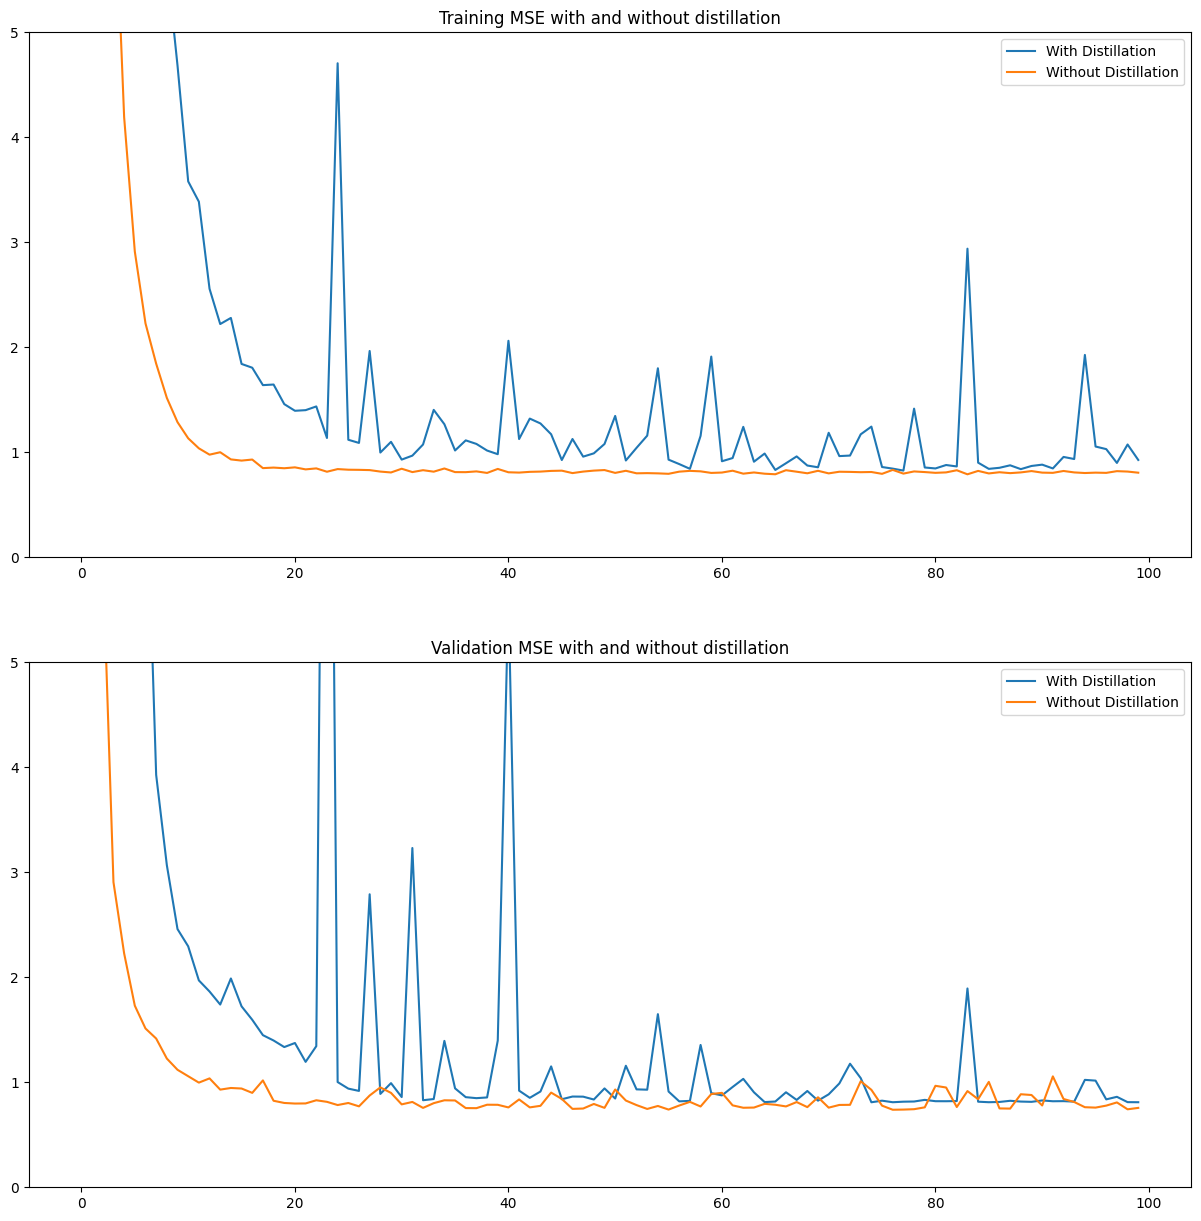

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:a] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.6531 +- 0.1775
Validation mse without disstillation 0.6429 +- 0.1354


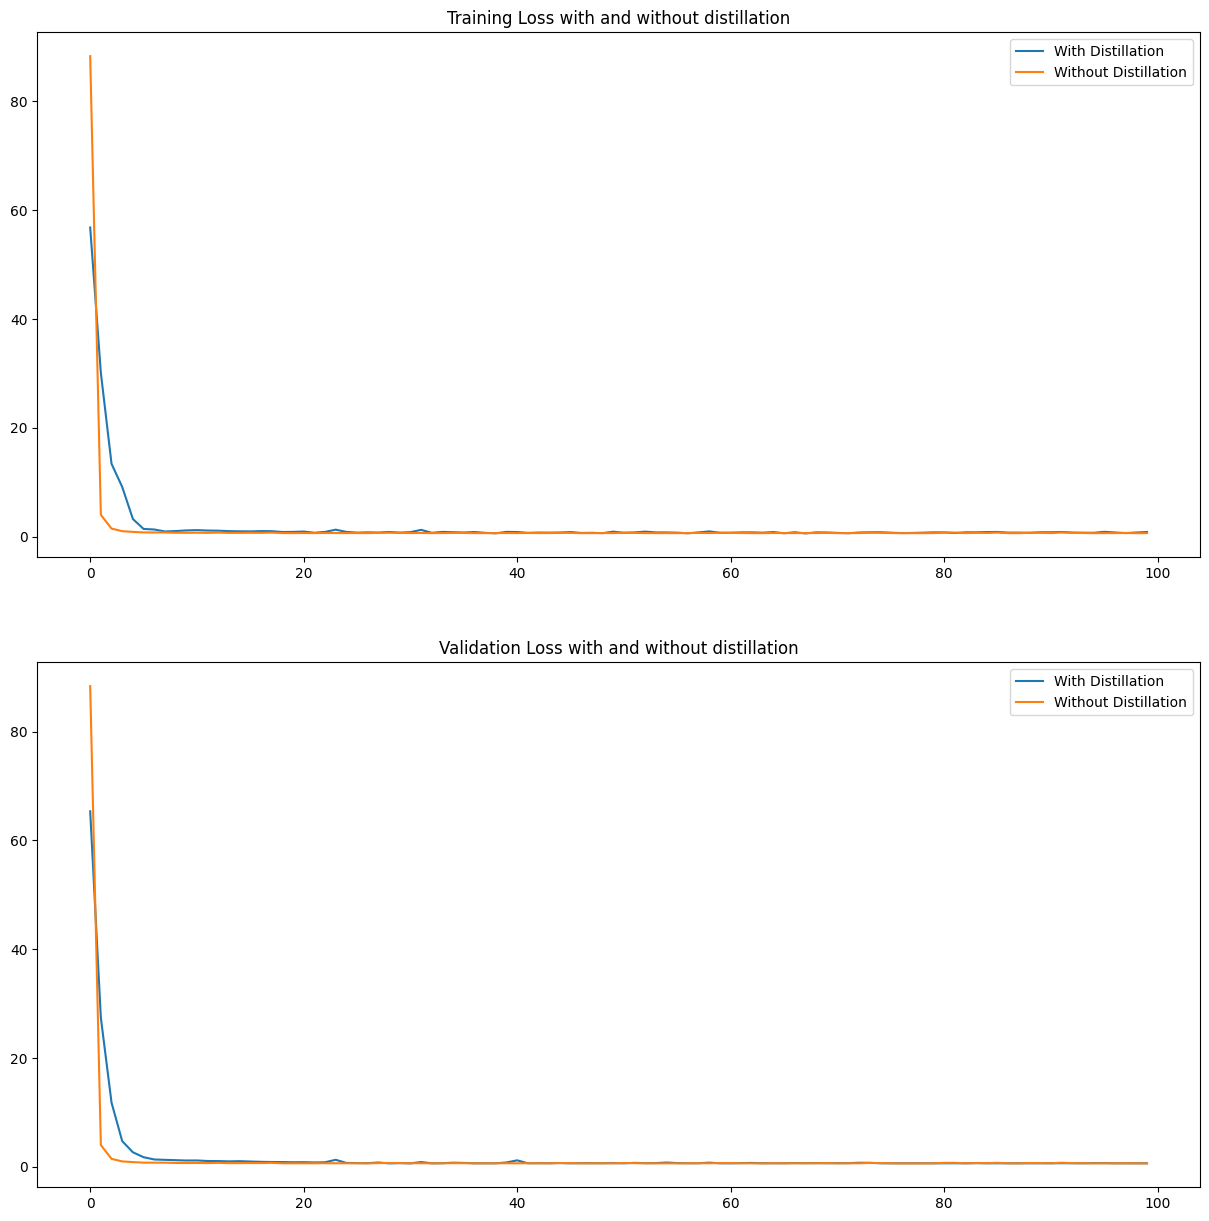

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [15]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - mse: 3.8419 - mae: 1.6947 - mape: 83.9676 - student_loss: 1.6933 - distillation_loss: 3.3763
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 2.5619 - mae: 1.2783 - mape: 57.3220 - student_loss: 1.2783 - distillation_loss: 2.1051
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 1.7623 - mae: 0.9993 - mape: 45.4699 - student_loss: 0.9981 - distillation_loss: 1.3082
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 1.3091 - mae: 0.8484 - mape: 43.6107 - student_loss: 0.8468 - distillation_loss: 0.8619
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 1.0845 - mae: 0.7855 - mape: 46.4282 - student_loss: 0.7855 - distillation_loss: 0.6414
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9912 - mae: 0.7707 - mape: 50.2255 - student_loss: 0.7717 - distillation_loss: 0.5516
Epoch 7/100
492/492 [=======

492/492 [==============================] - 1s 2ms/step - loss: 1.8926 - mse: 7.9278 - mae: 1.8926 - mape: 101.1233
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 1.2719 - mse: 2.7278 - mae: 1.2719 - mape: 58.2085
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9753 - mse: 1.7413 - mae: 0.9753 - mape: 45.6873
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8385 - mse: 1.2853 - mae: 0.8385 - mape: 44.3856
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7862 - mse: 1.0908 - mae: 0.7862 - mape: 46.5828
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7734 - mse: 1.0212 - mae: 0.7734 - mape: 48.7298
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7709 - mse: 1.0004 - mae: 0.7709 - mape: 49.6868
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9893 - mae: 0.7704 - mape: 50.3596
Epo

In [16]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 1.3325878381729126, 'mae': 0.8786646723747253, 'mape': 56.828208923339844, 'student_loss': 0.7910831570625305}
Test mse without disstillation {'loss': 0.8681605458259583, 'mse': 1.4017314910888672, 'mae': 0.8681605458259583, 'mape': 51.21242141723633}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
